In [126]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [127]:
DATA_DIR = 'C:\\Users\\Leila\\Desktop\\Python\\datasets\\plant-seedlings-classification\\'
sz = 224
batch_size = 32

In [128]:
os.listdir(DATA_DIR)

['sample_submission.csv', 'test', 'train', 'valid']

In [129]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}valid'

In [130]:
os.listdir(trn_dir)

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [131]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.png')
trn_fnames[:5]

['C:\\Users\\Leila\\Desktop\\Python\\datasets\\plant-seedlings-classification\\train\\Black-grass\\0050f38b3.png',
 'C:\\Users\\Leila\\Desktop\\Python\\datasets\\plant-seedlings-classification\\train\\Black-grass\\0183fdf68.png',
 'C:\\Users\\Leila\\Desktop\\Python\\datasets\\plant-seedlings-classification\\train\\Black-grass\\0260cffa8.png',
 'C:\\Users\\Leila\\Desktop\\Python\\datasets\\plant-seedlings-classification\\train\\Black-grass\\05eedce4d.png',
 'C:\\Users\\Leila\\Desktop\\Python\\datasets\\plant-seedlings-classification\\train\\Black-grass\\075d004bc.png']

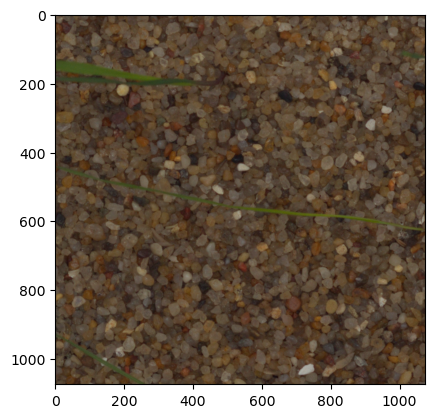

In [132]:
img = plt.imread(trn_fnames[5])
plt.imshow(img);

In [133]:
train_ds = datasets.ImageFolder(trn_dir)

In [134]:
train_ds.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [135]:
train_ds.class_to_idx

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [136]:
train_ds.root

'C:\\Users\\Leila\\Desktop\\Python\\datasets\\plant-seedlings-classification\\train'

# Transformations

In [137]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10),
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.3288, 0.2894, 0.2073], [0.0917, 0.0951, 0.1044])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
valid_ds = datasets.ImageFolder(val_dir, transform=tfms)

In [138]:
len(train_ds), len(valid_ds)

(4750, 721)

# Dataloaders

In [139]:
train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True, 
                                       num_workers=8)

valid_dl = torch.utils.data.DataLoader(valid_ds, 
                                       batch_size=batch_size, 
                                       shuffle=False, 
                                       num_workers=8)

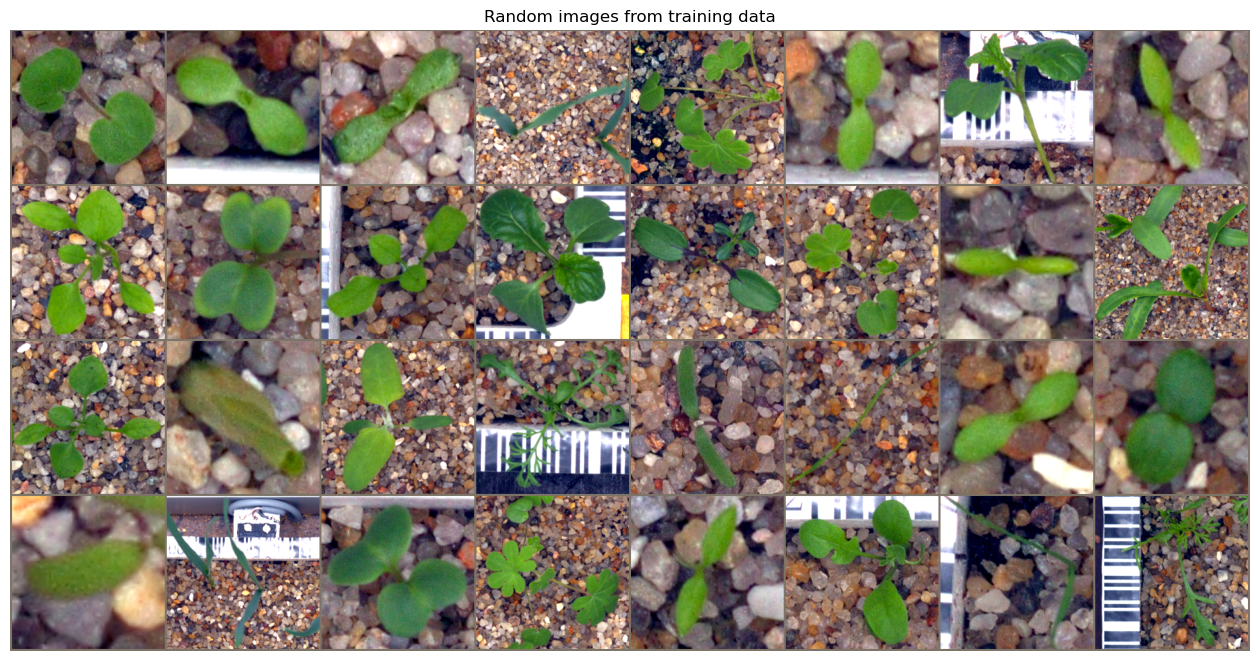

In [140]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')

# Model: CNN

In [141]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )   
        
        self.fc = nn.Linear(56 * 56 * 32, 12)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)            # (bs, C, H,  W) 
        out = out.view(out.size(0), -1)  # (bs, C * H, W)
        out = self.fc(out)
        return out

In [142]:
model = SimpleCNN()

# transfer model to GPU, if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

# Loss function and optimizer

In [143]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# Train

In [144]:
num_epochs = 5
losses = []

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # forwad pass
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, targets)
        losses.append(loss.item())

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.item()))

Epoch [ 1/ 5], Step [ 50/148], Loss: 3.1575
Epoch [ 1/ 5], Step [100/148], Loss: 1.4769
Epoch [ 2/ 5], Step [ 50/148], Loss: 0.9603
Epoch [ 2/ 5], Step [100/148], Loss: 0.7840
Epoch [ 3/ 5], Step [ 50/148], Loss: 0.6131
Epoch [ 3/ 5], Step [100/148], Loss: 1.0986
Epoch [ 4/ 5], Step [ 50/148], Loss: 0.5782
Epoch [ 4/ 5], Step [100/148], Loss: 0.6772
Epoch [ 5/ 5], Step [ 50/148], Loss: 0.5271
Epoch [ 5/ 5], Step [100/148], Loss: 0.3481


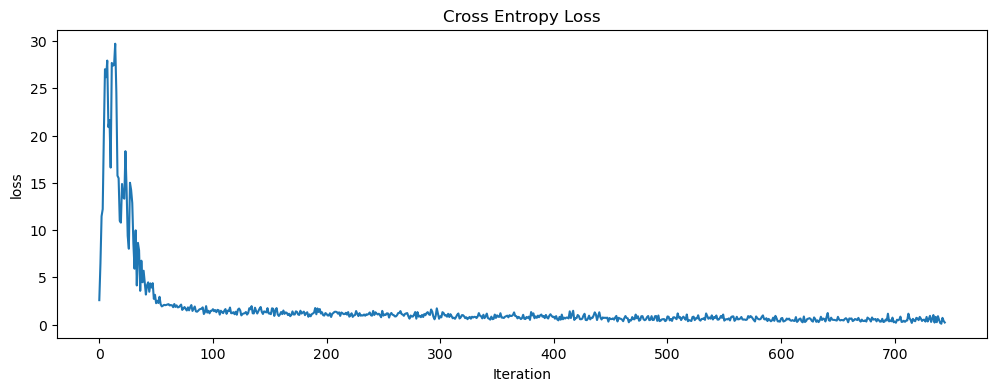

In [145]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

# Analyze results

In [146]:
def evaluate_model(model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [147]:
evaluate_model(model, valid_dl, device)

accuracy: 92.79


In [148]:
evaluate_model(model, train_dl, device)

accuracy: 91.71


# Confusion matrix

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:31<00:00,  1.35s/it]


[[0.82 0.   0.03 0.   0.05 0.03 0.07 0.   0.   0.   0.   0.  ]
 [0.   0.97 0.   0.   0.02 0.   0.   0.   0.   0.   0.02 0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.99 0.   0.   0.   0.   0.01 0.   0.   0.  ]
 [0.06 0.   0.   0.   0.85 0.03 0.   0.   0.03 0.03 0.   0.  ]
 [0.   0.   0.01 0.01 0.   0.89 0.04 0.   0.03 0.   0.   0.01]
 [0.02 0.   0.   0.   0.01 0.02 0.95 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.06 0.03 0.85 0.   0.   0.03 0.03]
 [0.01 0.   0.01 0.01 0.   0.   0.   0.03 0.9  0.01 0.   0.03]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.09 0.8  0.09 0.03]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.01]
 [0.   0.   0.02 0.   0.02 0.   0.   0.   0.02 0.   0.   0.95]]


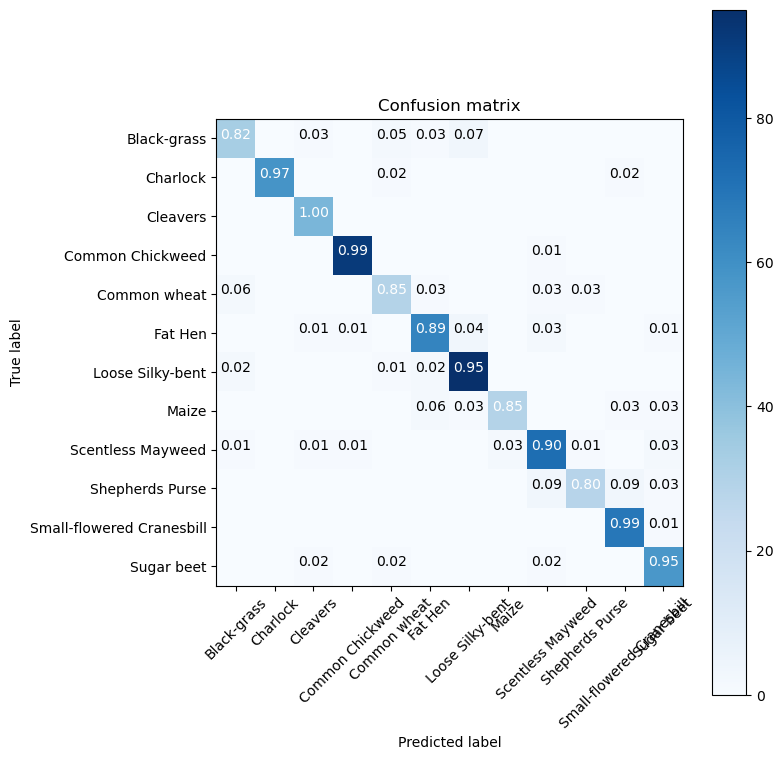

In [149]:
y_pred, y_true = predict_class(model, valid_dl, device)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(8, 8))

# Data Augmentation

In [160]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    #transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    #transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.3288, 0.2894, 0.2073], [0.0917, 0.0951, 0.1044])
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.3288, 0.2894, 0.2073], [0.0917, 0.0951, 0.1044])
])

train_ds = datasets.ImageFolder(f'{DATA_DIR}train', train_transforms)
valid_ds = datasets.ImageFolder(f'{DATA_DIR}valid', valid_transforms)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

class_names = train_ds.classes

Train size: 4750
Valid size: 721 (0.13)


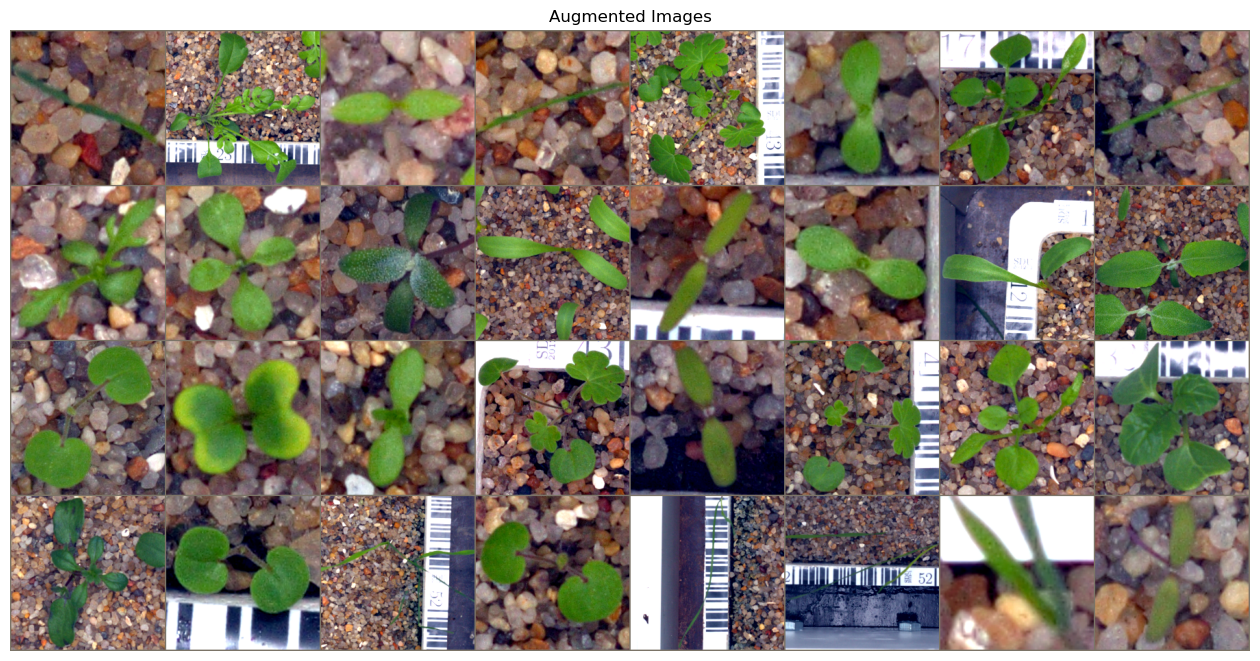

In [161]:
inputs, targets = next(iter(train_dl))     # Get a batch of training data
out = torchvision.utils.make_grid(inputs)  # Make a grid from batch
plt.figure(figsize=(16., 12.))
imshow(out, title='Augmented Images');

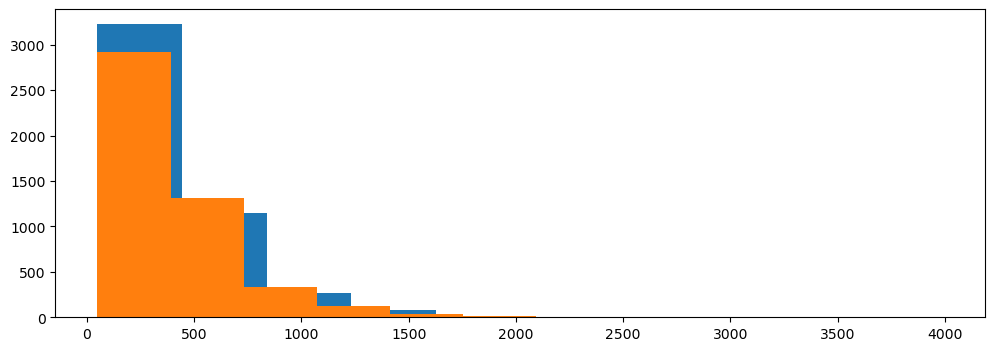

In [162]:
fnames = glob.glob(f'{trn_dir}/*/*.png')
sizes = [Image.open(f).size for f in fnames]

hs, ws = list(zip(*sizes))

plt.figure(figsize=(12., 4.))
plt.hist(hs)
plt.hist(ws);

In [163]:
# create model
model = SimpleCNN()
model = model.to(device)
    
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# train
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, num_epochs=5)

Epoch 1/5
----------
  train Loss: 5.37318 Acc: 0.34063
  valid Loss: 1.26638 Acc: 0.61442

Epoch 2/5
----------
  train Loss: 1.17296 Acc: 0.62611
  valid Loss: 0.80695 Acc: 0.74896

Epoch 3/5
----------
  train Loss: 0.89799 Acc: 0.70547
  valid Loss: 0.73881 Acc: 0.78225

Epoch 4/5
----------
  train Loss: 0.75844 Acc: 0.75158
  valid Loss: 0.48897 Acc: 0.84882

Epoch 5/5
----------
  train Loss: 0.66650 Acc: 0.78568
  valid Loss: 0.44343 Acc: 0.87933

Training complete in 29m 10s
Best val Acc: 0.8793


# Transfer Learning

In [164]:
# load pre-trained ResNet18
model = load_pretrained_resnet50(model_path=None, num_classes=12)
model = model.to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [165]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, scheduler, num_epochs=2)

Epoch 1/2
----------
  train Loss: 0.85205 Acc: 0.72589
  valid Loss: 0.15832 Acc: 0.94452

Epoch 2/2
----------
  train Loss: 0.18094 Acc: 0.94253
  valid Loss: 0.06670 Acc: 0.98474

Training complete in 100m 26s
Best val Acc: 0.9847


In [166]:
evaluate_model(model, valid_dl, device)

accuracy: 98.47
